<a href="https://colab.research.google.com/github/SkyWaet/Coursework-third-year/blob/main/Coursework_third_year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая Работа


In [1]:
import zipfile

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/new_data.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/new_data') #Extracts the files into the /tmp folder
#zip_ref.close()

train_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/train_11_cor.zip', 'r')
val_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/val_11_cor.zip', 'r')
test_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/test_11_cor.zip', 'r')

train_zip.extractall('/train')
val_zip.extractall('/val')
test_zip.extractall('/test')

train_zip.close()
val_zip.close()
test_zip.close()

from shutil import copy,copyfile
copy('/content/drive/MyDrive/Coursework_third_year/SinDataset.py','/content')

'/content/SinDataset.py'

In [ ]:
from shutil import copyfile
copyfile('/content/SinDataset.py','/content/drive/MyDrive/Coursework_third_year/SinDataset.py')

'/content/drive/MyDrive/Coursework_third_year/SinDataset.py'

In [2]:
import torch.optim as optim
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
from torch.utils.data import DataLoader
from SinDataset import SinDataset
from torchvision import transforms
from torchvision import models
from torch.utils.data import random_split
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train_path = '/train'
val_path = '/val'
test_path = '/test'

transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.CenterCrop(224),
     transforms.ToTensor()])

train_ds = SinDataset(info=f'/{train_path}/info.csv', root_dir=f'{train_path}',
                     transform=transform)
val_ds = SinDataset(info=f'/{val_path}/info.csv', root_dir=f'{val_path}',
                     transform=transform)
test_ds = SinDataset(info=f'/{test_path}/info.csv', root_dir=f'{test_path}',
                     transform=transform,test=True)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=128, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, pin_memory=True)
print(train_ds[0]['image'].size())

torch.Size([3, 224, 224])


In [5]:
print(len(test_dl))
print(len(test_ds))

66
8360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.int64


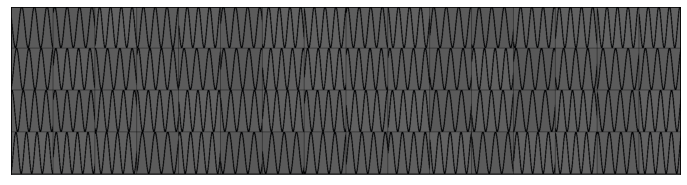

In [36]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_batch(dl):
    for index, elem in enumerate(dl):   
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(elem["image"], nrow=16).permute(1, 2, 0))
        print(elem["frequency"].dtype)
        break
show_batch(train_dl)

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images = batch["image"].to(self.device,non_blocking=True)
        labels = batch["frequency"].to(self.device,non_blocking=True)  
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):        
        images = batch["image"].to(self.device,non_blocking=True)
        labels = batch["frequency"].to(self.device,non_blocking=True) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class FrequencyDetectorModel(ImageClassificationBase):
    def __init__(self,device):
        super().__init__()
        self.device = device
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(16,16), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            #nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 128 x 32 x 32

            #nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 256 x 16 x 16          

            nn.Flatten(), 
            nn.Linear(6272, 1024*4),
            nn.ReLU(),            
            nn.Linear(1024*4, 512),
            nn.ReLU(),
            nn.Linear(512, 11),
            nn.LogSoftmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for _,batch in enumerate(val_loader)]
    return model.validation_epoch_end(outputs)

def fit_old(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for _,batch in enumerate(train_loader):            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = FrequencyDetectorModel(device).to(device)

In [22]:
evaluate(model, val_dl)

{'val_acc': 0.09063824266195297, 'val_loss': 2.3985166549682617}

In [23]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [24]:
history = fit_old(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 5.7507, val_loss: 2.4393, val_acc: 0.0906
Epoch [1], train_loss: 2.3652, val_loss: 2.4391, val_acc: 0.0906
Epoch [2], train_loss: 2.3653, val_loss: 2.4395, val_acc: 0.0906
Epoch [3], train_loss: 2.3652, val_loss: 2.4367, val_acc: 0.0906
Epoch [4], train_loss: 2.3653, val_loss: 2.4353, val_acc: 0.0906
Epoch [5], train_loss: 2.3652, val_loss: 2.4405, val_acc: 0.0906
Epoch [6], train_loss: 2.3650, val_loss: 2.4473, val_acc: 0.0906
Epoch [7], train_loss: 2.3652, val_loss: 2.4403, val_acc: 0.0906
Epoch [8], train_loss: 2.3650, val_loss: 2.4403, val_acc: 0.0906
Epoch [9], train_loss: 2.3654, val_loss: 2.4376, val_acc: 0.0906


In [ ]:
_,preds = torch.max(model(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)


In [ ]:
print(test_dataset.frequencies[preds])
print(test_dataset.frequencies[0])

52.2
45.0


In [ ]:
print(accuracy_new(model,test_dl))

<h1>Fit</h1>

In [31]:
def fit_new(model,criterion,n_epochs,path):
 
  optimizer = optim.Adam(model.parameters()) 
  n_epochs_stop = 5
  min_val_loss = np.Inf
  epochs_no_improve = 0
  checkpoint_path = f'/content/drive/MyDrive/Coursework_third_year/{path}.pth'

  # Main loop
  for epoch in range(n_epochs):
    # Initialize validation loss for epoch
    val_loss = 0
    print(f'Epoch = {epoch}')
    # Training loop
    for i,batch in enumerate(train_dl):
      # Generate predictions
      data = batch["image"].to(device)
      targets = batch["frequency"].to(device)
      out = model(data)
      # Calculate loss
      loss = criterion(out, targets)
      # Backpropagation
      loss.backward()
      # Update model parameters
      optimizer.step()
      batch["image"].to('cpu')
      batch["frequency"].to('cpu')
      
  # Validation loop
    for i,batch in enumerate(val_dl):
      # Generate predictions 
      data = batch["image"].to(device)
      targets = batch["frequency"].to(device)
      out = model(data)
      # Calculate loss
      loss = criterion(out, targets)
      val_loss += loss

    # Average validation loss
    val_loss = val_loss / len(val_ds)
    print(f'val los = {val_loss}')
    # If the validation loss is at a minimum
    if val_loss < min_val_loss:
      # Save the model
      torch.save(model, checkpoint_path)
      epochs_no_improve = 0
      min_val_loss = val_loss
      
    else:
      epochs_no_improve += 1
      # Check early stopping condition
      if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break      
        # Load in the best model

<h1>VGG16</h1>

In [7]:
from torchvision import models
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [8]:
for param in vgg.parameters():
    param.requires_grad = False

In [9]:
vgg.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 11),                   
                      nn.LogSoftmax(dim=1))

In [ ]:
vgg.to(device)

In [11]:
fit_new(vgg,nn.NLLLoss(),10,'best_vgg')

Epoch = 0
val los = 0.01973215863108635
Epoch = 1
val los = 0.019022969529032707
Epoch = 2
val los = 0.019239163026213646
Epoch = 3
val los = 0.019373400136828423
Epoch = 4
val los = 0.01904265396296978
Epoch = 5
val los = 0.019590407609939575
Epoch = 6
val los = 0.019029216840863228
Early stopping!


In [33]:
@torch.no_grad()
def accuracy_new(model,test_dl):
  correct_match = 0
  for i,batch in enumerate(test_dl):
      data = batch["image"].to(device)
      targets = batch["frequency"].to(device)
      res = torch.exp(model(data)) 
      _,out = torch.max(res,dim=1)
      print(res)
      print('targets = ')
      print(targets)
      print('out = ')
      print(out)
      print("====")
      correct_match += torch.sum(out==targets).item()
  return correct_match/len(test_ds)


In [16]:
best_vgg = torch.load('/content/drive/MyDrive/Coursework_third_year/best_vgg.pth')
print(accuracy(best_vgg,test_dl))

targets = 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
out = 
tensor([9, 9, 9, 9, 9, 9, 8, 9, 2, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 2, 9, 9, 2, 9, 9,
        9, 9, 9, 9, 9, 8, 8, 9], device='cuda:0')
====
targets = 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

KeyboardInterrupt: ignored

In [ ]:
succeeded = 0
for i,batch in enumerate(test_loader):
  image = batch["image"].to(device)
  frequency = batch["frequency"]
  log_ps = best_model(data)
  # Convert to probabilities
  ps = torch.exp(log_ps)
  # Find predictions and correct
  pred = torch.max(ps, dim=1)
  equals = pred == targets
  # Calculate accuracy
  accuracy = torch.mean(equals) 
print(succeeded/len(test_dataset))

TypeError: ignored

<h1>SqueezeNet</h1>

In [ ]:
sq = models.squeezenet1_0(pretrained=True)
print(sq)


In [ ]:
for param in sq.parameters():
    param.requires_grad = False

In [ ]:
sq.classifier[3] = nn.Sequential(
                      nn.Conv2d(1000, 101, kernel_size=(1, 1), stride=(1, 1)),
                      nn.ReLU(inplace=True),
                      nn.AdaptiveAvgPool2d(output_size=(1, 1))
                      )

In [ ]:

# Loss and optimizer


In [ ]:
sq.to(device)

In [ ]:
fit_new(sq,5,'sq_net')

NameError: ignored

In [ ]:
_,preds = torch.max(sq(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)
preds = preds.item()

In [ ]:
print(preds)

31


In [ ]:
print(test_dataset[0]["frequency"])

35


<h1>ResNet</h1>

In [ ]:
resnet = models.resnet152(pretrained=True)


In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
resnet.fc = nn.Linear(in_features=2048,out_features=101)


In [ ]:
resnet.to(device)

In [ ]:
fit_new(resnet,5,'resnet_152')

Epoch = 0
val los = 102.95545959472656
Epoch = 1
val los = 140.02198791503906
Epoch = 2


KeyboardInterrupt: ignored

In [ ]:
_,preds = torch.max(resnet(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)
preds = preds.item()
print(preds)
print(test_dataset[0]["frequency"])

59
15


<h1>GoogleNet</h1>

In [ ]:
google = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
print(google)

In [ ]:
for param in google.parameters():
    param.requires_grad = False

In [ ]:
google.fc = nn.Linear(in_features=1024,out_features=11,bias=True)

In [ ]:
google.to(device)

In [ ]:
fit_new(google,nn.CrossEntropyLoss() ,10,'google')

Epoch = 0
val los = 0.47756344079971313
Epoch = 1


KeyboardInterrupt: ignored

In [ ]:
best_google = torch.load('/content/drive/MyDrive/Coursework_third_year/google.pth')

In [ ]:
print(accuracy(best_vgg,test_dl))